# Image Edge Detection
This kernel applies a compass edge detection filter on a grayscale image using sobel operators on 8 directions.

Each pixel in the input or output images is packed in a 32bit word.

## Get FGPU iPython Package
In case the FGPU IPython package is not installed, you may install it by executing the command below.

In [ ]:
!sudo -H pip install --upgrade 'git+https://github.com/malkadi/FGPU_IPython'

## Kernel Code
The OpenCL code of your kernel can be edited here. It will be atomatically saved to the file named in the first line.

In [1]:
%%writefile OpenCL_code/compass_edge_detection.cl
#include "FGPUlib.c"

__kernel void compass_edge_detection(__global unsigned *in, __global unsigned *out)
{
  unsigned x = get_global_id(1);
  unsigned y = get_global_id(0);
  unsigned rowLen = get_global_size(0);


  // return on boarder pixels
  bool border =  x < 1 | y < 1 | (x>rowLen-2) | (y>rowLen-2);
  if(border) 
    return;
  //read pixels
  unsigned p[3][3];
  unsigned p00 = in[(x-1)*rowLen+y-1];
  unsigned p01 = in[(x-1)*rowLen+y];
  unsigned p02 = in[(x-1)*rowLen+y+1];
  unsigned p10 = in[x*rowLen+y-1];
  unsigned p11 = in[x*rowLen+y];
  unsigned p12 = in[x*rowLen+y+1];
  unsigned p20 = in[(x+1)*rowLen+y-1];
  unsigned p21 = in[(x+1)*rowLen+y];
  unsigned p22 = in[(x+1)*rowLen+y+1];
  int G[8] = {0};
  //find edges in 4 directions
  G[0] =  -1*p00 +0*p01 +1*p02 +
          -2*p10 +0*p11 +2*p12 +
          -1*p20 +0*p21 +1*p22;
  G[1] =  -2*p00 -1*p01 +0*p02 +
          -1*p10 +0*p11 +1*p12 +
          -0*p20 +1*p21 +2*p22;
  G[2] =  -1*p00 -2*p01 -1*p02 +
          -0*p10 +0*p11 +0*p12 +
          +1*p20 +2*p21 +1*p22;
  G[3] =  -0*p00 -1*p01 -2*p02 +
          +1*p10 +0*p11 -1*p12 +
          +2*p20 +1*p21 +0*p22;
  //compute the edges in the remaining 4 directions by inversion
  G[4] = -G[0];
  G[5] = -G[1];
  G[6] = -G[2];
  G[7] = -G[3];
  //taking the maximum value on all directions
  int max_val = G[0], i;
  for(i = 1; i < 8; i++)
    max_val = G[i] < max_val ? max_val:G[i];
  //write the result to output
  out[x*rowLen+y] = max_val;
}


Overwriting OpenCL_code/compass_edge_detection.cl


## Create Objects

In [1]:
from FGPU import FGPU
from FGPU import xlnk

fgpu= FGPU()
mem=xlnk.xlnk() #This object is needed to manage memory operations
mem.cma_stats() # prints some statistics on memory usage

{'Buffer Count': 0, 'CMA Memory Available': 133464064, 'CMA Memory Usage': 0}

## Program Hardware

In [2]:
fgpu.set_bitFile("bitstreams/V2_8CUs_250MHz.bit")
fgpu.download_bitstream()

## Compile Kernel

In [3]:
fgpu.set_kernel_file("OpenCL_code/compass_edge_detection.cl")
fgpu.compile_kernel()

Compiling /home/muhammed/FGPU_IPython/notebooks/OpenCL_code/compass_edge_detection.cl
Compiling succeeded!




## Read Input Image & Allocate Memory

In [4]:
import pickle
import sys
from cffi import FFI
import numpy as np
ffi = FFI()

#read input image
with open('data/lena.dat', 'rb') as f:
    img = np.array(pickle.load(f))
nRows, nCols = img.shape # get image dimensions
length = img.size # length of input and output array

# Allocate continuous memory for kernel parameters
img_ptr = mem.cma_alloc(length, data_type = "unsigned") # for input image
edges_fgpu = mem.cma_alloc(length, data_type = "unsigned") # for output image

# copy the input image to CMA region
if type(img) == np.ndarray:
    ffi.memmove(img_ptr, img, img.size*img.dtype.itemsize) 
else:
    AssertionError()
mem.cma_stats() #prints some statistics on memory usage

{'Buffer Count': 2,
 'CMA Memory Available': 131837952,
 'CMA Memory Usage': 2097152}

## Configure Kernel

In [5]:
# bind allocated memory to kenel parameters
fgpu.set_paramerter(0, img_ptr, mem)
fgpu.set_paramerter(1, edges_fgpu, mem)
# setup index space
fgpu.set_num_dimensions(2)
fgpu.set_size(size=nCols, dim=0)
fgpu.set_size(size=nRows, dim=1)
fgpu.set_work_group_size(wg_size=8, dim=0)
fgpu.set_work_group_size(wg_size=8, dim=1)
fgpu.set_offset(value=0, dim=0)
fgpu.set_offset(value=0, dim=1)

## Execute On FGPU

In [7]:
#download kernel binary code and settings to hardware
fgpu.download_kernel()
#execute and wait until finish
execTime = fgpu.execute_kernel()
print ("Execution time =", int(execTime*1000), "ms")

Execution time = 4 ms


### Show input & output images

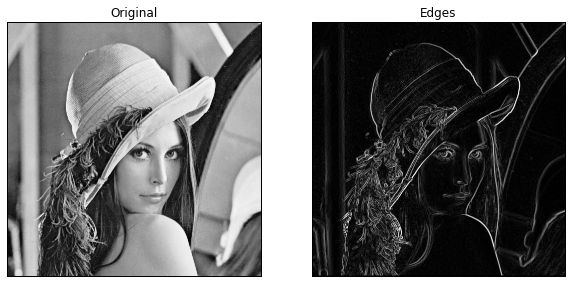

In [9]:
from matplotlib import pyplot as plt
import numpy as np

#reshape result image
buffer_size = img.size*img.dtype.itemsize
c_buffer = ffi.buffer(edges_fgpu,buffer_size)
res_fgpu_ndarray = np.frombuffer(c_buffer, dtype=img.dtype)
res_fgpu = res_fgpu_ndarray.reshape(img.shape)

#plot original and computed images
plt.figure(1, figsize=(10, 10))
plt.subplot(121),plt.imshow(img, cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(res_fgpu, cmap='Greys_r'),plt.title('Edges')
plt.xticks([]), plt.yticks([])
plt.show()

## Compute without FGPU
Here the same task will be executed in python 

Execution time = 264 ms


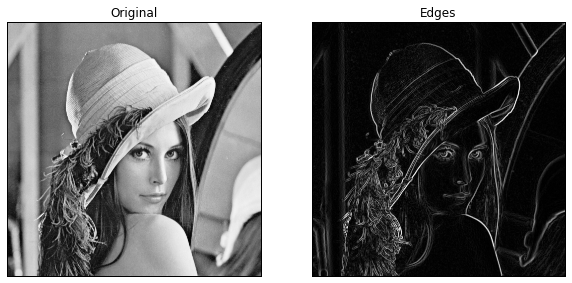

In [10]:
import numpy as np
import scipy.ndimage
import time
from matplotlib import pyplot as plt

def detect_edges(image,masks):
    # This function filters "image" with all filters in "masks" and returns the maxilim result for each pixel
    edges = abs(scipy.ndimage.convolve(image,masks[0]))
    for mask in masks[1:4]:
        edges=np.maximum(abs(scipy.ndimage.convolve(image,mask)), edges)
    return edges

# Sobel operators for edge detection
Sobel=[
        [
        [-1,+0,+1],
        [-2,+0,+2],
        [-1,+0,+1]
        ],
        [
        [-2,-1,+0],
        [-1,+0,+1],
        [+0,+1,+2]
        ],
        [
        [-1,-2,-1],
        [+0,+0,+0],
        [+1,+2,+1]
        ],
        [
        [-0,-1,-2],
        [+1,+0,-1],
        [+2,+1,+0]
        ] 
]

#compute task
start = time.time()
edges=detect_edges(img, Sobel)
end = time.time()
print ("Execution time =", int((end-start)*1000), "ms")

#plot input and output images
plt.figure(1, figsize=(10, 10))
plt.subplot(121),plt.imshow(img, cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap='Greys_r'),plt.title('Edges')
plt.xticks([]), plt.yticks([])
plt.show()

## Check Results
The results of python and FGPU execution will be compared and any mismatch will be reported

In [11]:
res_fgpu_array = mem.cma_cast(edges_fgpu, "int")
nErrors = 0
for i in range(1, nRows-1):
    for j in range(1, nCols-1):
        if edges[i][j] != res_fgpu_array[i*nCols+j]:
            nErrors += 1;
            
if nErrors == 0:
    print ("no Errors found!")
else:
    print (nErrors, "Errors found!")

no Errors found!
